In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *
from rayoptics.mpl.analysisfigure import Wavefront, RayFanPlot, RayGeoPSF, AnalysisFigure
from rayoptics.gui import dashboards

from matplotlib import gridspec
import matplotlib.colors as mcolors

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Create a new model

In [3]:
app = AppManager(None)
opm = app.model = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']
print(f"{opm.ro_version=}")

opm.ro_version='0.9.5'


### Define first order aperture and field for system

In [4]:
pupil_diameter = 40.
pupil_radius = pupil_diameter/2
osp.pupil = PupilSpec(osp, key=['object', 'epd'], value=pupil_diameter)

# single field on-axis
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.0])

# wavelength for analysis: 550nm
osp.spectral_region = WvlSpec([(550.0, 1.0)], ref_wl=0)

### object at infinity, i.e. collimated input

In [5]:
sm.gaps[0].thi = 1e+11

### setup aperture stop surface, then offset mirror behind the aperture stop

In [6]:
mirror_offset = srf.DecenterData('dec and return', y=0.)
opm.add_dummy_plane(sd=pupil_radius, decenter=mirror_offset)
sm.set_stop();

### add parabolic mirror and enable it to tip, tilt and offset

In [7]:
offset_aperture = srf.Circular(radius=pupil_diameter, y_offset=0.)
mirror_perturb = srf.DecenterData('dec and return', y=-pupil_radius)
opm.add_mirror(power=1/80, cc=-1, t=-80, sd=pupil_diameter,
               decenter=mirror_perturb, clear_apertures=[offset_aperture])

In [8]:
sm.do_apertures = False

### all of the system data has been entered, update the model

In [9]:
opm.update_model()

In [10]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
 Stop:     0.000000      0.00000       air             1      20.000
    2:    -0.006250     -80.0000       air    reflect -1      40.000
  Img:    -0.000000      0.00000                      -1      20.000


In [11]:
sm.list_sg()

               c               mode              type          y       alpha
                       t           medium
  Obj:      0.00000                 
                 1.00000e+11          air
 Stop:      0.00000                      dec and return     0.0000     0.0000
                     0.00000          air
    2:  -0.00625000          reflect     dec and return    -20.000     0.0000
                    -80.0000          air
  Img:     -0.00000                 


In [12]:
listobj(sm)

0: Obj: dummy
profile: Spherical
c=0.0,   r=0.0
surface_od=0.0
t=100000000000.0 (+1);    medium: air

1 (stop): dummy
profile: Spherical
c=0.0,   r=0.0
decenter type: dec and return
decenter: [0. 0. 0.]
euler angles: [0. 0. 0.]
surface_od=20.0
t=0.0 (+1);    medium: air

2: reflect
profile: Conic
c=-0.00625,   r=-160.0   conic cnst=-1
decenter type: dec and return
decenter: [  0. -20.   0.]
euler angles: [0. 0. 0.]
surface_od=39.999999999
ca: radius=39.999999999
t=-80 (-1);    medium: air

3: Img: dummy
profile: Spherical
c=-0.0,   r=0.0
surface_od=20.000000016

do apertures: False


# List first order data

In [13]:
pm.first_order_data()

efl                 -80
f                    80
f'                  -80
ffl                 -80
pp1                   0
bfl                 -80
ppk                  -0
pp sep                0
f/#                   2
m                -8e-10
red           -1.25e+09
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius           20
na obj            2e-10
n obj                 1
img_dist            -80
img_ht            1.396
exp_dist       -6.4e-08
exp_radius           20
na img             0.25
n img                -1
optical invariant       0.3491


# Draw a lens picture

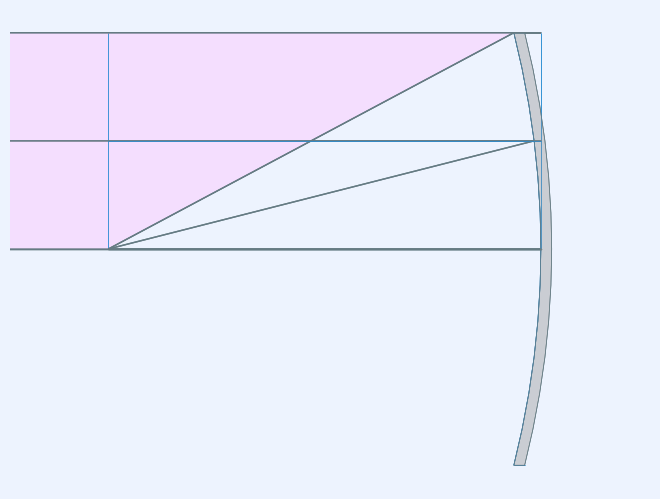

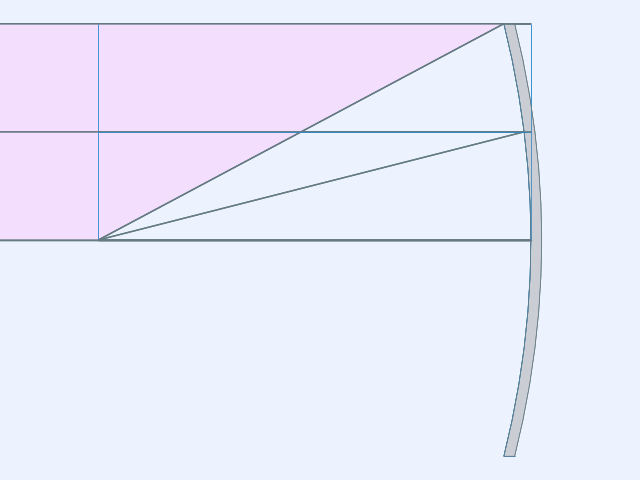

In [14]:
isdark = False
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, refresh_gui=app.refresh_gui,
                        do_draw_rays=True, do_paraxial_layout=False, is_dark=isdark).plot()

app.add_figure(layout_plt)

In [15]:
fld, wvl, foc = osp.lookup_fld_wvl_focus(0)

In [16]:
optical_axis_ray = trace_ray(opm, [0., 0.], fld, wvl)
list_ray(optical_axis_ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000        -1.25
  2:      0.00000     20.00000        -1.25     0.000000    -0.246154    -0.969231        81.25
  3:      0.00000    -20.00000            0     0.000000    -0.246154    -0.969231            0


## Use the built-in Spot Diagram plot

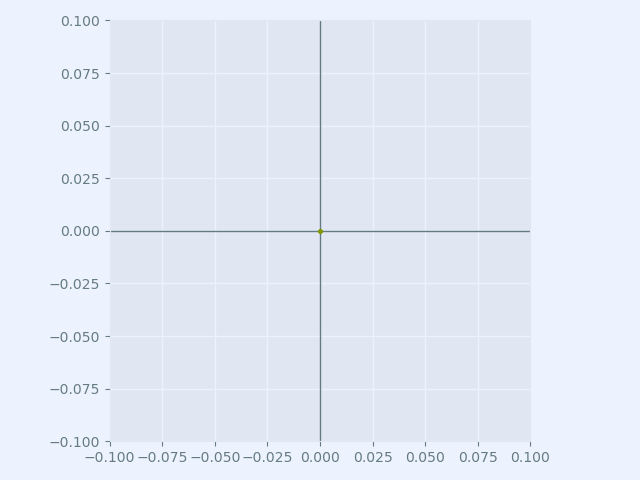

In [17]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.1, is_dark=isdark).plot()

## Add tilt to mirror

In [18]:
#sm.ifcs[2].decenter.euler[0] = 0.00573  # 0.1 mrad mirror tilt
sm.ifcs[2].decenter.euler[0] = 0.0573  # 1 mrad mirror tilt
opm.update_model()

### Redo Spot diagram with tilted mirror

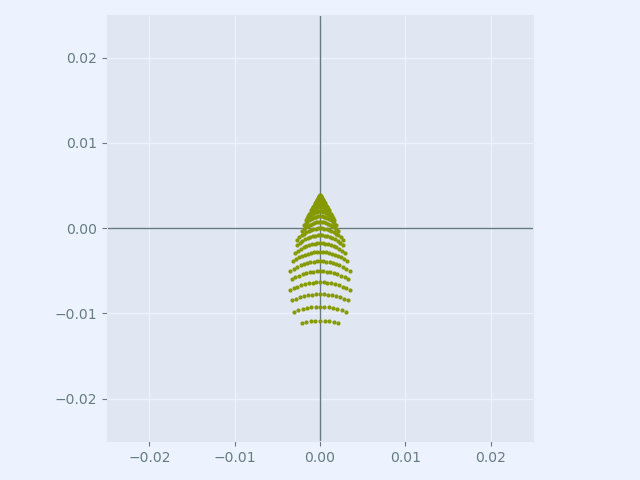

In [19]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
                      user_scale_value=0.025, is_dark=isdark).plot()

In [20]:
image_pt, ref_dir, ref_sphere_radius, lcl_tfrm_last = fld.ref_sphere

In [21]:
image_pt

array([  0.        , -20.16389492,   0.        ])

In [22]:
fld.ref_sphere[0][1]=0

In [23]:
image_pt

array([0., 0., 0.])

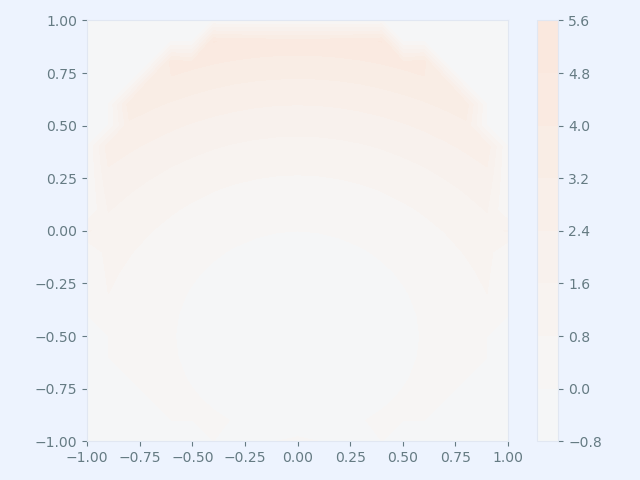

In [24]:
wavefront_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=opm, scale_type=Fit.User_Scale,
                 user_scale_value=50., is_dark=isdark).plot()

# Start of dynamic dashboard

## Set up the reference image point for the aberration calculations.

    Use the central ray from the on axis field point and take it's coordinates on the image interface as the definition for the on-axis image point

In [25]:
ctr_ray_result = trace_ray(opm, [0., 0.], fld, wvl)
ctr_ray = ctr_ray_result.pkg.ray

img_offset = ctr_ray[-1][0]
on_axis_pt = np.array([img_offset[0], img_offset[1]])

## Set up the data sources for the plots.

### RayGrid

    Used to trace and manage a grid of rays at a specific field and wavelength,
        specifically to construct a grid representation of a wavefront.
    grid_pkg attribute contains all of the ray data in the grid (all surfaces)
    grid attribute contains the opd and the pupil coord values

### RayList

    Used to trace an arbitrary list of rays at a specific field and wavelength
        specifically to collect the ray coordinates on the (defocused) image plane
    ray_list attribute contains all of the ray data in the list (all surfaces)
    ray_abr attribute contains the x and y aberration values with respect to the
    (defocused) image_pt_2d

In [26]:
ray_grid = analyses.RayGrid(opm, num_rays=48, f=fld, wl=wvl, image_pt_2d=on_axis_pt)
ray_list = analyses.RayList(opm, num_rays=48, f=fld, wl=wvl, image_pt_2d=on_axis_pt)

## Set up useful measures

    To control the sensitivity of the control widgets below, calculate magnitudes of 1 wave perturbations.

In [27]:
# one wave in system units
opd = opm.nm_to_sys_units(wvl)

# one wave of defocus
fod = ar['parax_data'].fod
dfoc = opd/(fod.img_na**2/(2*fod.n_img))
qwrt_dfoc = abs(0.25*dfoc)

# one wave of tilt
_, _, ref_sphere_radius, _ = fld.ref_sphere
shft = ref_sphere_radius*opd/fod.exp_radius

## Wavefront and Ray Aberration Display

In [28]:
opd_scale = 5

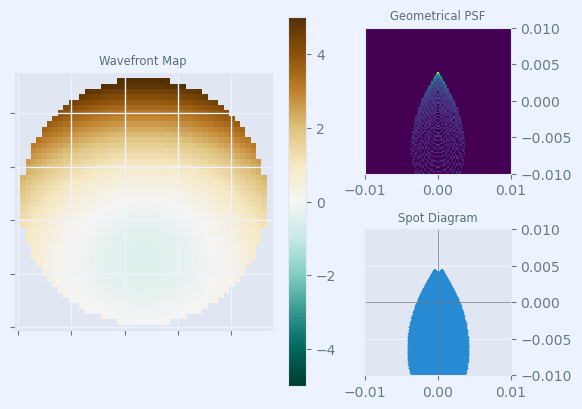

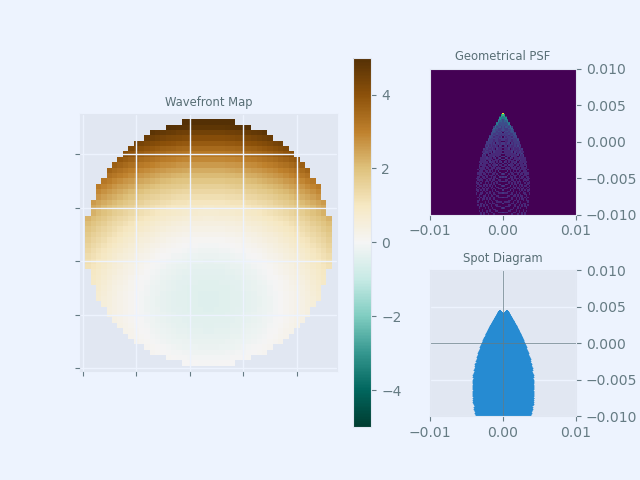

In [29]:
fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list],
                 grid=(2, 3), is_dark=isdark)
#gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

wfr = Wavefront(ray_grid, user_scale_value=opd_scale, do_contours=False, title='Wavefront Map',
                cmap="BrBG_r")
us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='right', title='Geometrical PSF')
sPOT = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')
fig.subplots = [wfr, gPSF, sPOT]
fig.gridspecs = [fig.gs[:2, :2], fig.gs[:1, -1:], fig.gs[-1:, -1:]]
fig.plot()

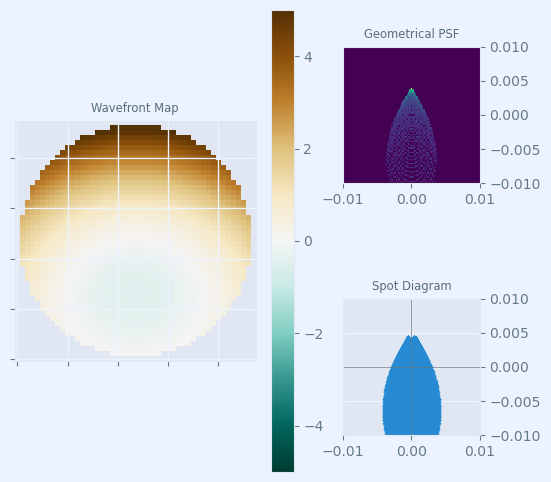

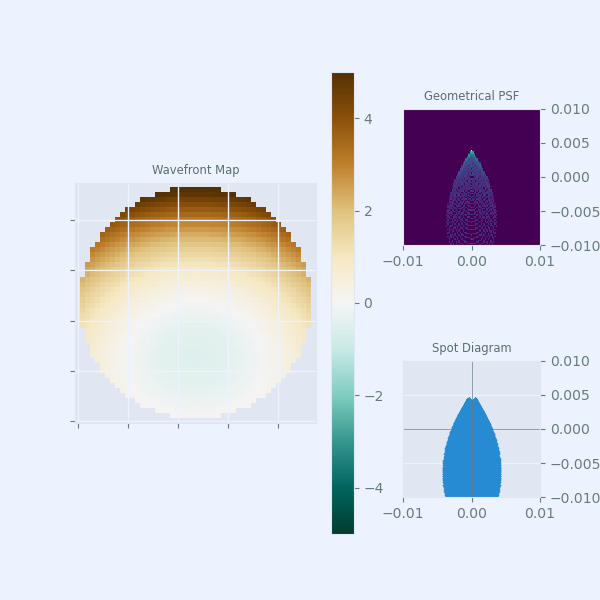

In [30]:
wfr = Wavefront(ray_grid, user_scale_value=opd_scale, do_contours=False, title='Wavefront Map',
                cmap="BrBG_r")
us = 0.01
scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='right', title='Geometrical PSF')
sPOT = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')

fig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_grid, ray_list], subplots=[wfr, gPSF, sPOT],
                 grid=(2, 3), figsize=[6, 6], is_dark=isdark)
fig.gridspecs = [fig.gs[:2, :2], fig.gs[:1, -1:], fig.gs[-1:, -1:]]
#gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

fig.plot()

In [31]:
image_defocus = ray_grid.foc
image_delta = ray_grid.image_delta
defocus, x_shift, y_shift = dashboards.create_focus_dashboard([fig],
                                                              [ray_grid, ray_list],
                                                              image_defocus, abs(dfoc), 0.2, image_delta)
display(widgets.HBox([defocus, y_shift]))

## 2D Histogram and Spot Diagram

    This plot shows both a spot diagram and a 2D histogram display, using the same RayList instance as used above.

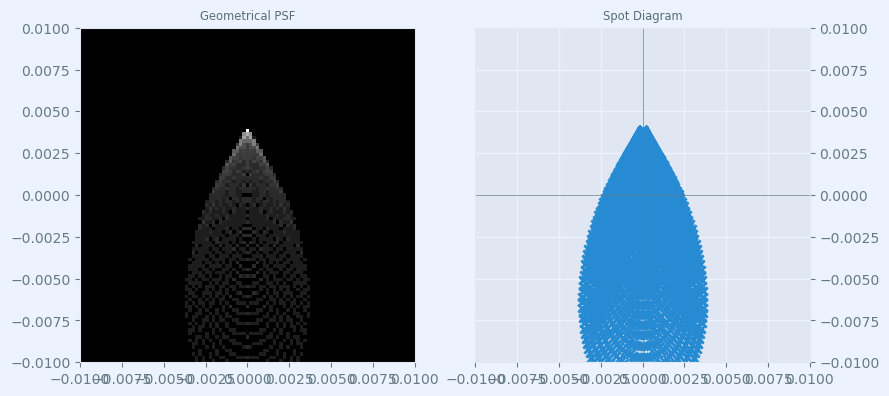

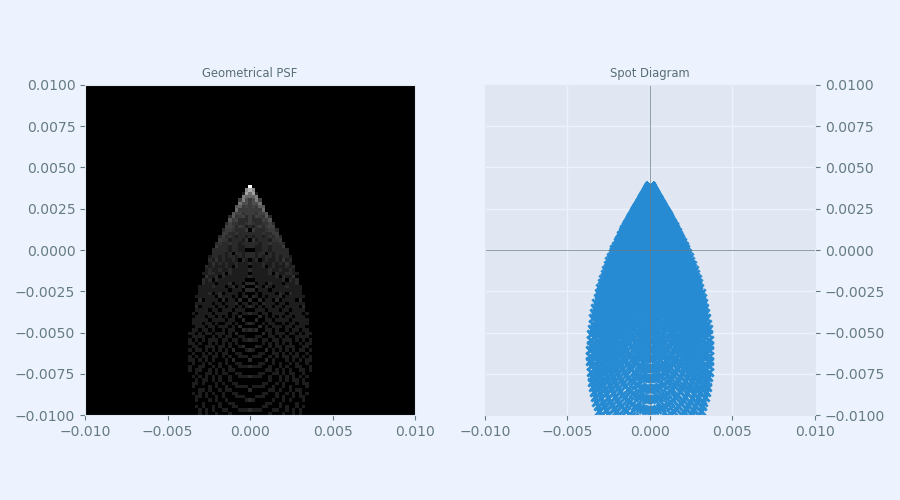

In [32]:
us = 0.01
#scaler = mcolors.Normalize(vmin=0., vmax=80)
gPSF = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                 yaxis_ticks_position='left', title='Geometrical PSF', cmap='gray')
gSPO = RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='spot',
                 yaxis_ticks_position='right', title='Spot Diagram', marker='x')

spotfig = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list], subplots=[gPSF, gSPO],
                     grid=(1, 2), figsize=[9, 5], tight_layout=True, is_dark=isdark)
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=spotfig)

spotfig.plot()

## 2D Histogram with x and y histogram slices

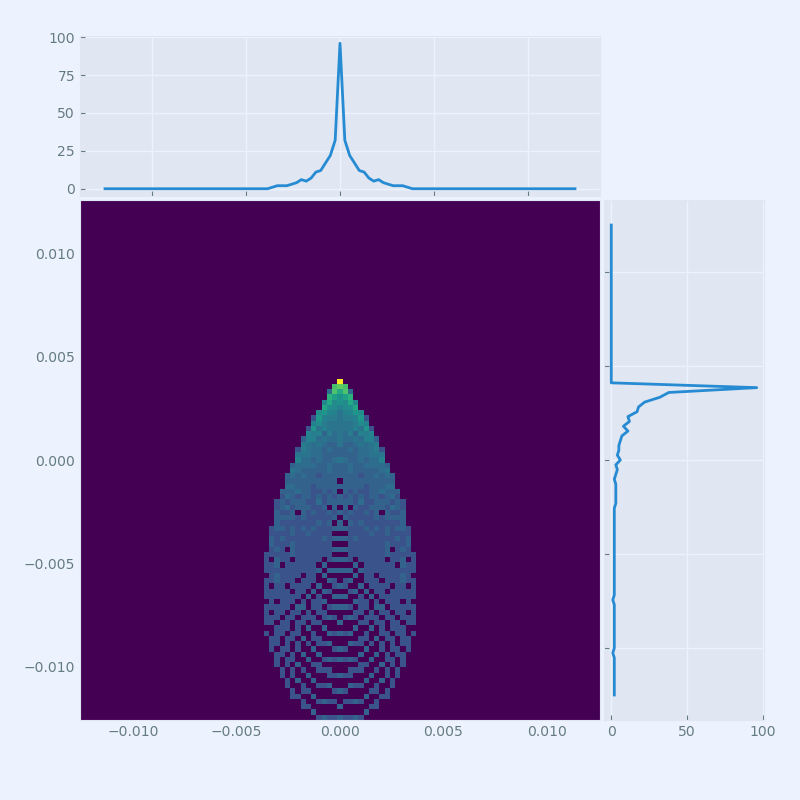

In [33]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_hist2d = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_hist2d = plt.axes(rect_hist2d)
ax_hist2d.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
#ax_hist2d.scatter(x, y)
x_data = ray_list.ray_abr[0]
y_data = ray_list.ray_abr[1]
max_value = max(max(np.nanmax(x_data), -np.nanmin(x_data)),
                max(np.nanmax(y_data), -np.nanmin(y_data)))

bins = 30
edges = np.linspace(-max_value, max_value, num=100)
gamma = 0.3
dset = ax_hist2d.hist2d(*ray_list.ray_abr, bins=edges, norm=mcolors.PowerNorm(gamma))
h, xedges, yedges, qmesh = dset
ax_hist2d.set_facecolor(qmesh.cmap(0))

# now determine nice limits by hand:
binwidth = 0.0025
#lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
#ax_hist2d.set_xlim((-lim, lim))
#ax_hist2d.set_ylim((-lim, lim))

#bins = np.arange(-lim, lim + binwidth, binwidth)
centers = np.linspace(-max_value, max_value, num=99)
ax_histx.plot(centers, np.max(h, axis=1))
ax_histy.plot(np.max(h, axis=0), centers)

#ax_histx.set_xlim(ax_hist2d.get_xlim())
#ax_histy.set_ylim(ax_hist2d.get_ylim())

plt.show()

## 2D Histogram with mirror tilt control

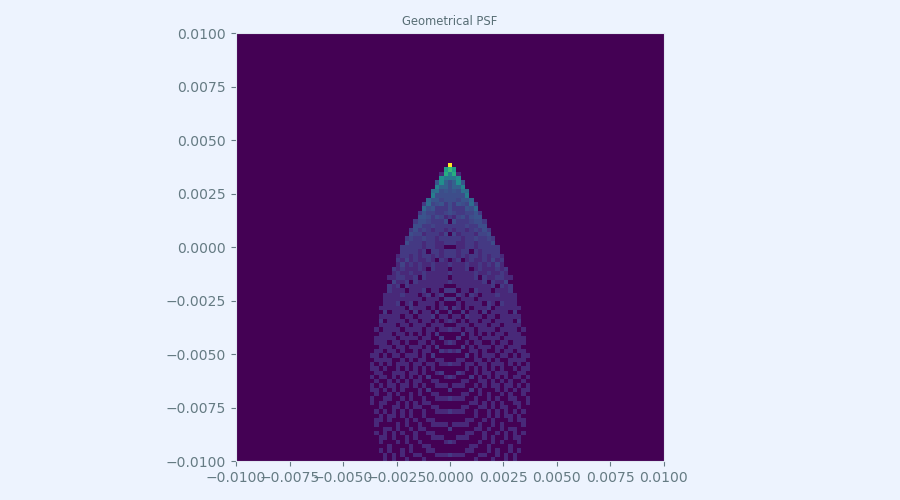

In [34]:
gPSF = RayGeoPSF(ray_list, user_scale_value=.01, scale_type='user', dsp_typ='hist2d',
                 title='Geometrical PSF')

fig_hist = plt.figure(FigureClass=AnalysisFigure, data_objs=[ray_list], subplots=[gPSF],
                 figsize=[9, 5], tight_layout=True, is_dark=isdark)

fig_hist.refresh()

tilt_rng = 0.1146
tilt_rng = 100*shft/ref_sphere_radius
shift_rng = shft

alpha_tilt, x_dec, y_dec = dashboards.create_mirror_tilt_dashboard(sm.ifcs[2], app,
                                                                   [fig_hist], [ray_list],
                                                                   foc, tilt_rng, shift_rng,
                                                                   continuous_update=False)
display(widgets.HBox([alpha_tilt, x_dec, y_dec]))

### Number of rays in the RayList instance

In [35]:
len(ray_list.ray_abr[0])

2304

In [36]:
len(ray_grid.grid_pkg)

2

In [37]:
len(ray_grid.grid_pkg[0])

48

In [38]:
len(ray_grid.grid_pkg[1])

48

In [39]:
ray_grid.grid_pkg[0][24][24]

[np.float64(0.02170212765957437),
 np.float64(0.02170212765957437),
 ([[array([0., 0., 0.]),
    array([4.34042553e-12, 4.34042553e-12, 1.00000000e+00]),
    np.float64(100000000000.0),
    array([-0., -0.,  1.])],
   [array([0.43404255, 0.43404255, 0.        ]),
    array([4.34042553e-12, 4.34042553e-12, 1.00000000e+00]),
    np.float64(-1.3260370471542062),
    array([-0., -0.,  1.])],
   [array([ 0.43404255, 20.43535847, -1.30560084]),
    array([-0.00533772, -0.25230795, -0.96763227]),
    np.float64(81.32689021654592),
    array([0.0026909 , 0.12669137, 0.99193853])],
   [array([-5.79790029e-05, -2.01640686e+01,  0.00000000e+00]),
    array([-0.00533772, -0.25327553, -0.96737946]),
    0.0,
    array([-0., -0.,  1.])]],
  np.float64(-1.3260370471542062),
  550.0)]

In [40]:
list_ray(ray_grid.grid_pkg[0][24][24][2])

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.43404      0.43404            0     0.000000     0.000000     1.000000       -1.326
  2:      0.43404     20.43536      -1.3056    -0.005338    -0.252308    -0.967632       81.327
  3:     -0.00006    -20.16407            0    -0.005338    -0.253276    -0.967379            0


In [41]:
ray_grid.grid_pkg[1][24][24]

(np.float64(-3.0460496347473054e-09),
 array([ 0.43374408,  0.41988996, -0.10993201]),
 array([ 0.43404255,  0.43405255, -1.30603558]),
 array([-0.00533772, -0.25327553, -0.96737946]))

In [42]:
list_ray(trace_ray(opm, [-1, -1], fld, wvl))

            X            Y            Z           L            M            N               Len
  0:     -0.00000     -0.00000            0    -0.000000    -0.000000     1.000000        1e+11
  1:    -20.00000    -20.00000            0    -0.000000    -0.000000     1.000000        -1.25
  2:    -20.00000      0.00125        -1.25     0.246154    -0.001015    -0.969230        81.25
  3:      0.00003    -20.16126            0     0.246154    -0.001985    -0.969229            0


In [43]:
sm.ifcs[1].point_inside(-20, -20)

np.False_

In [44]:
ray_grid.grid_pkg[0][0][0]

[np.float64(-1.02), np.float64(-1.02), None]

In [45]:
plt.isinteractive()

True